In [ ]:
!pip install deeplake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences

In [ ]:
import deeplake
ds = deeplake.load('hub://activeloop/flickr30k')

hub://activeloop/flickr30k loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add# load vgg19 model\
from tensorflow.keras.backend import get_value

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Flickr8k_Dataset.zip", 'r')
zip_ref.extractall("/content/flikr_images")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Flickr8k_text.zip", 'r')
zip_ref.extractall("/content/flikr_text")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


FileNotFoundError: ignored

In [ ]:
def load_image(image_id):
  img = ds.image[image_id].numpy()
  img = tf.image.resize(img, [32,32])
  # img = img.numpy().reshape(32, 32, 3)
  img = np.reshape(img,(32*32*3))
  return img

In [ ]:
def load_image1(name):
    img = image.load_img(name,target_size=(32,32,3))
    print(img)
    # print(img.shape)
    img = image.img_to_array(img)
    print(img)
    print(img.shape)
    #img = img/255
    #plt.imshow(img)
    img = np.reshape(img,(32*32*3))
    print(img)
    print(img.shape)
    return img

In [ ]:
import os

image_arr = []
sentence_arr = []

for i in range(len(ds.image)):
    try:
        img_name = i
        image_processed = load_image(i)

        # for k in range(1,6):
        image_arr.append(image_processed)

        caption_0 = ds.caption_0[i].data()["value"]
        sentence_arr.append('<SOS> '+caption_0 +' <EOS>')
            
    except:
        pass

Images =  np.array(image_arr)

In [ ]:
len(sentence_arr)

31783

In [ ]:
# image_arr_5000 = image_arr[0:5000]
# sentence_arr_5000 = sentence_arr[0:5000]

In [ ]:
sentence_arr[0]

'<SOS> Crowds of people are walking are multicolored tents and flags that are put up outside in a cement lot as a big city looms in the distance . <EOS>'

In [ ]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(x)
    t=tokenizer.texts_to_sequences(x)
    # TODO: Implement
    return t, tokenizer

In [ ]:
# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [ ]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [ ]:
def preprocess(sentences):
    text_tokenized, text_tokenizer = tokenize(sentences)
    text_pad = pad(text_tokenized)
    return text_pad, text_tokenizer

# Sentence , token_Sentence = preprocess(sentence_arr)

In [ ]:
# Images = np.array(image_arr_5000)
Sentence , token_Sentence = preprocess(sentence_arr)

In [ ]:
print("Sentence vocabulary size:", len(token_Sentence.word_index))
print("Sentence Longest sentence size:", len(Sentence[0]))

Sentence vocabulary size: 12316
Sentence Longest sentence size: 80


In [ ]:
Images.shape , Sentence.shape

((31783, 3072), (31783, 80))

In [ ]:
Sentence[0]

array([   2, 2280,    9,   25,   17,   47,   17,  634, 1367,    6,  540,
         64,   17, 1048,   52,   82,    4,    1,  639,  362,   39,    1,
        293,  145, 4360,    4,    5,  329,    3,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [ ]:
def create_batch(src, tar , batchsize , i):
    src, tar =  np.transpose(src[(i-1)*batchsize : (i-1)*batchsize + batchsize]) , np.transpose(tar[(i-1)*batchsize : (i-1)*batchsize + batchsize])
    return torch.tensor(src).long(),torch.tensor(tar).long()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len_s,
        max_len_t,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len_s, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Model hyperparameters
src_vocab_size = 256
trg_vocab_size = len(token_Sentence.word_index)
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len_s = Images.shape[1]
max_len_t = len(Sentence[0])
forward_expansion = 4
src_pad_idx = 0

In [ ]:
# Training hyperparameters
num_epochs = 10000
learning_rate = 3e-4
batch_size = 1

In [ ]:
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len_s,
    max_len_t,
    device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).cuda()

In [ ]:
import math

In [ ]:
import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0
    start_time = time.time()
    for i in range(1, 999):
        src,tar = create_batch(Images,Sentence, batch_size , i)
        src = src.to(device)
        tar = tar.to(device)
        optimizer.zero_grad()
        output = model(src,tar)
        loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        cur_loss = loss.item()
        total_loss += cur_loss
        log_interval = 100
        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  's/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, i, (src.shape[1]) // batch_size, 
                    elapsed  / log_interval,
                    cur_loss, math.exp(cur_loss)))
            start_time = time.time()
    return total_loss

In [ ]:
import math
for epoch in range(1, 3):
    epoch_start_time = time.time()
    loss = train()
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | Training loss {:5.2f} | '
          .format(epoch, (time.time() - epoch_start_time),
                                     loss))

| epoch   1 |   100/    1 batches | s/batch  0.16 | loss  5.61 | ppl   271.80
| epoch   1 |   200/    1 batches | s/batch  0.16 | loss  3.89 | ppl    48.79
| epoch   1 |   300/    1 batches | s/batch  0.16 | loss  2.10 | ppl     8.16
| epoch   1 |   400/    1 batches | s/batch  0.16 | loss  2.26 | ppl     9.56
| epoch   1 |   500/    1 batches | s/batch  0.16 | loss  2.81 | ppl    16.67
| epoch   1 |   600/    1 batches | s/batch  0.16 | loss  1.83 | ppl     6.26
| epoch   1 |   700/    1 batches | s/batch  0.16 | loss  0.69 | ppl     1.98
| epoch   1 |   800/    1 batches | s/batch  0.16 | loss  2.63 | ppl    13.83
| epoch   1 |   900/    1 batches | s/batch  0.16 | loss  3.08 | ppl    21.80
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 158.35s | Training loss 3076.62 | 
| epoch   2 |   100/    1 batches | s/batch  0.16 | loss  1.39 | ppl     4.01
| epoch   2 |   200/    1 batches | s/batch  0.16 | loss  0.31 | ppl

In [ ]:
import matplotlib.pyplot as plt

def evaluate(index):
    my_image_arr = []
    img = load_image(index)
    my_image_arr.append(img)
    my_image_arr = np.array(image_arr)
    print(my_image_arr)

    my_sentence = []
    sent = sentence_arr[index]
    my_sentence.append(sent)

    # sentence[0] = '<SOS> '+sentence[0]+' <EOS>'
    print(my_sentence)

    my_sentence = pad(token_Sentence.texts_to_sequences(my_sentence) , length = max_len_t)
    src , tar = create_batch(my_image_arr,my_sentence, 1,1)
    src = src.to(device)
    tar = tar.to(device)
    model.eval()
    output =  model(src,tar)
    loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
    sentence_formed = ''
    val, ind = torch.max(output.view(-1, output.shape[2]), 1)
    for word in ind:
        #print('--->'+sentence_formed+'    '+str(word.item()))
        if word.item() == 3: # EOS
                break
        for key, value in token_Sentence.word_index.items():
            #print(value == word.item())
            if value == word.item() and value != 2: # sos
                sentence_formed = sentence_formed + key +' '
                break
    #from PIL import Image
    plt.imshow(ds.image[index])
    return sentence_formed , loss


[[113.57031   130.57031   156.57031   ...  39.808594   26.792969
   11.8125   ]
 [206.28711   205.4082    212.42578   ... 155.13867   153.62305
  150.13867  ]
 [ 30.75       34.7041     27.404297  ... 181.71973   136.36816
  127.85254  ]
 ...
 [159.39648   160.77148   159.36523   ... 204.18848   206.18848
  203.18848  ]
 [ 53.20996    34.70703    26.137695  ... 143.28125    88.65625
   54.96875  ]
 [ 45.76953    50.76953    43.76953   ...   2.7128906   2.7128906
    1.5488281]]
['<SOS> A security officer with a tiny face and big glasses leans on a metal gate looking into the camera . <EOS>']


('a security officer with a tiny face and big glasses carriage on a metal gate looking into the camera ',
 tensor(0.5234, device='cuda:0', grad_fn=<NllLossBackward0>))

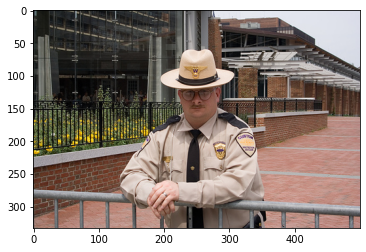

In [ ]:
evaluate(2)

In [ ]:
ds.caption_0[0]

/usr/local/lib/python3.8/dist-packages/deeplake/core/tensor.py:601: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Tensor(key='caption_0', index=Index([0]))

In [ ]:
ds.caption_0[0]

Tensor(key='caption_0', index=Index([0]))

In [ ]:
print(ds.caption_0[0].data()['value'])

Crowds of people are walking are multicolored tents and flags that are put up outside in a cement lot as a big city looms in the distance .
